In [1]:
import pandas as pd
import rdflib
from rdflib import Graph, Literal, Namespace, RDF, URIRef, OWL
from rdflib.extras.external_graph_libs import rdflib_to_networkx_digraph
from rdflib.namespace import DC, FOAF
import matplotlib.pyplot as plt
import numpy as np
import networkx.algorithms.community as nx_comm
import networkx as nx
from owlready2 import *
from owlready2 import get_ontology
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import networkx.algorithms.community as nx_comm

* Owlready2 * Warning: optimized Cython parser module 'owlready2_optimized' is not available, defaulting to slower Python implementation


In [2]:
onto = get_ontology("http://example.org/medsur.owl")

class Patients(Thing):
    namespace = onto

class AgeGroup(Thing):
    namespace = onto
 
class hasAgeGroup(ObjectProperty):                  # TODO: do we need to define ranges for our properties?
    domain = [Patients]
    range = [AgeGroup]
    namespace = onto
  
class WeightGroup(Thing):
    namespace = onto
    
class hasWeightGroup(ObjectProperty):   # is this range correct if we connect patient directly to weightgroup is rdf tripple, else delete range
    domain = [Patients]
    range = [WeightGroup]
    namespace = onto
    
class Symptoms(Thing):
    namespace = onto
    
class hasSymptom(ObjectProperty):
    domain = [Patients]
    range = [Symptoms]
    namespace = onto

class Outcome(Thing):
    namespace = onto
    
class hasOutcome(ObjectProperty):
    domain = [Patients]
    range = [Outcome]
    namespace = onto
    
class Gender(Thing):
    namespace = onto

class hasGender(ObjectProperty):
    domain = [Patients]
    range = [Gender]
    namespace = onto

class Drug(Thing):
    namespace = onto
    
class isPrescribedFor(ObjectProperty):
    domain = [Drug]
    range = [str]
    namespace = onto
    
class IsGivenDrug(ObjectProperty):
    domain = [Patients]
    range = [Drug]
    namespace = onto
    
class IsOfDosis(ObjectProperty):
    domain = [Drug]
    namespace = onto
    
class IsOfType(ObjectProperty):
    domain = [Drug]
    namespace = onto

class SideEffects(Thing):
    namespace = onto
    
class hasSideEffect(ObjectProperty):
    domain = [Drug]
    range = [SideEffects]
    namespace = onto
    
class hasFrequency(ObjectProperty):                 
    domain = [SideEffects]
    namespace = onto 

class suffersSideEffects(ObjectProperty):
    domain = [Patients]
    range = [SideEffects]
    namespace = onto

In [3]:
onto.save(file = "medsur.rdf", format = "rdfxml") 
g = rdflib.Graph()
g.parse("medsur.rdf", format="xml")

# Loop through each triple in the graph (subj, pred, obj)
for subj, pred, obj in g:
    
    # Check if there is at least one triple in the Graph
    if (subj, pred, obj) not in g:
       raise Exception("It better be!")

# Print the number of "triples" in the Graph
print(f"Graph g has {len(g)} statements.")

Graph g has 50 statements.


In [4]:
data_patients = pd.read_excel('output_opioid.xlsx')
data_patients.head()
data_patients = data_patients[:100]

In [5]:

data_sideeffects = pd.read_excel("sider_output.xlsx")
data_sideeffects.head()

,Unnamed: 0,STITCH code,ATCode,ATCText,PTConcept,Side effect,PTCode,Frequency
0,0,CID100002476,N02AE01,buprenorphine,C0000731,Abdominal distension,10000060,NaN
1,1,CID100002476,N02AE01,buprenorphine,C0687713,Gastrointestinal pain,10017999,NaN
2,2,CID100002476,N02AE01,buprenorphine,C0000737,Abdominal pain,10000081,NaN
3,3,CID100002476,N02AE01,buprenorphine,C0000833,Abscess,10000269,1.1%
4,4,CID100002476,N02AE01,buprenorphine,C0000833,Abscess,10000269,1.11%


In [6]:
def clean_data(data):
    
    data[:100]
    # change all values in column "ID" to string
    data= data.astype(str)

    # replace all NaN, None, NaT, NULL, - values with empty string
    data = data.replace("NAN", '', regex=True)
    data = data.replace("nan", '', regex=True)
    data = data.replace("NaN", '', regex=True)
    data = data.replace("None", '', regex=True)
    data = data.replace('NaT', '', regex=True)
    data = data.replace('NULL', '', regex=True)
    data = data.replace('-', '', regex=True)
    data = data.replace("\+", '', regex=True)
    data = data.replace(" ", '_', regex=True)
    data = data.replace("\?", '', regex=True)
    data = data.replace("%", '', regex=True)
    return data


data_patients = clean_data(data_patients)
data_sideeffects = clean_data(data_sideeffects)
    
# replace all "" values in Age and BMI to "0"
data_patients["age_year"] = data_patients["age_year"].replace('', '0')
data_patients['BMI'] = data_patients['BMI'].replace('', '0')

In [8]:
# add RDF triples to the ontology
EX = rdflib.Namespace("http://www.medsur.org/")

for index, row in data_patients.iterrows():    
    
    patient = URIRef(f"http://www.medsur.org/patient_{row['ID']}")                     
    g.add((patient, RDF.type, EX.Patients))    
      
    if float(row["BMI"]) >= 30:                                 
        weightgroup = URIRef("http://www.medsur.org/weight/Obese")                   # TODO: do we need to define the subclasses of weightgroup?
    elif float(row["BMI"]) >= 25:
        weightgroup = URIRef("http://www.medsur.org/weight/Overweight")
    elif float(row["BMI"]) >= 18.5:
        weightgroup = URIRef("http://www.medsur.org/weight/Normal")
    elif float(row["BMI"]) < 18.5:
        weightgroup = URIRef("http://www.medsur.org/weight/Underweight")

    if weightgroup:                                   
        g.add((weightgroup, RDF.type, EX.WeightGroup))
        g.add((patient, EX.hasWeightGroup, weightgroup))
    
    if float(row["age_year"]) >= 65:
        agegroup = URIRef("http://www.medsur.org/age/65_above")
    elif float(row["age_year"]) >= 45:
        agegroup = URIRef("http://www.medsur.org/age/45_64") 
    elif float(row["age_year"]) >= 25:
        agegroup = URIRef("http://www.medsur.org/age/25_44")
    elif float(row["age_year"]) >= 18:
        agegroup = URIRef("http://www.medsur.org/age/18_24")
    
    if agegroup:
        g.add((agegroup, RDF.type, EX.AgeGroup))
        g.add((patient, EX.hasAgeGroup, agegroup))
    
    if row["sex"] == "male" or row["sex"] == "female":
        gender = URIRef(f"http://www.medsur.org/gender/{row['sex']}")
        g.add((gender, RDF.type, EX.Gender))
        g.add((patient, EX.hasGender, gender))
            
    if row["Outcome"] != "Unknown" or row["Outcome"] != "":  
        outcome = URIRef(f"http://www.medsur.org/outcome/{row['Outcome']}")
        g.add((outcome, RDF.type, EX.Outcome))
        g.add((patient, EX.hasOutcome, outcome))
      
    if row["PTCode"] != "":
        symptom = URIRef(f"http://www.medsur.org/symptom/{row['PTCode']}")
        g.add((symptom, RDF.type, EX.Symptoms))
        g.add((patient, EX.hasSymptom, symptom))
      
    if row["ATCode"] != "":
        drug = URIRef(f"http://www.medsur.org/drug/{row['ATCode']}")              
        g.add((drug, RDF.type, EX.Drug))   
        g.add((patient, EX.isGivenDrug, drug))
        
        if row["PTCode"] != "":
            g.add((drug, EX.isPrescribedFor, symptom))
  
        if row["Dosis"] != "":
            g.add((drug, EX.isOfDosis, Literal(row["Dosis"])))              # TODO: do we need to define a class for dosis and type?
        if row["Type"] != "":
            g.add((drug, EX.isOfType, Literal(row["Type"])))                                              

        df_sideeffects = data_sideeffects.loc[data_sideeffects['ATCode'] == row["ATCode"]]
  
        for index, row2 in df_sideeffects.iterrows():
            if row2["PTCode"] != "":
                side_effect = URIRef(f"http://www.medsur.org/side_effect/{row2['PTCode']}")
                g.add((side_effect, RDF.type, EX.SideEffects))
                g.add((drug, EX.hasSideEffect, side_effect))
                
                
                # check if any side_effect is present in patient file
                if row2['PTCode'] == row["PTCode"]:
                    g.add((patient, EX.suffersSideEffect, side_effect))                           
                
                if row2["Frequency"] != "":
                    g.add((side_effect, EX.hasFrequency, Literal(row2['Frequency'])))         # TODO: do we need to define a class for frequency? 

In [9]:
# print all the triples in the graph 
for s, p, o in g:
    print(s, p, o)

http://www.medsur.org/drug/N02AE01 http://www.medsur.org/isPrescribedFor http://www.medsur.org/symptom/10080284
http://www.medsur.org/drug/N02AX02 http://www.medsur.org/hasSideEffect http://www.medsur.org/side_effect/10046543
http://www.medsur.org/side_effect/10013573 http://www.medsur.org/hasFrequency 5.26
http://www.medsur.org/side_effect/10003036 http://www.medsur.org/hasFrequency 9
http://www.medsur.org/side_effect/10037211 http://www.w3.org/1999/02/22-rdf-syntax-ns#type http://www.medsur.org/SideEffects
http://www.medsur.org/drug/N02AB03 http://www.medsur.org/hasSideEffect http://www.medsur.org/side_effect/10028813
http://www.medsur.org/side_effect/10067152 http://www.w3.org/1999/02/22-rdf-syntax-ns#type http://www.medsur.org/SideEffects
http://www.medsur.org/drug/N02AB03 http://www.medsur.org/hasSideEffect http://www.medsur.org/side_effect/10065929
http://www.medsur.org/side_effect/10003658 http://www.w3.org/1999/02/22-rdf-syntax-ns#type http://www.medsur.org/SideEffects
http://w

In [10]:
nx_graph = rdflib_to_networkx_digraph(g)
print("Number of Nodes: {n}".format(n=nx.number_of_nodes(nx_graph)))
print("Number of Edges: {n}".format(n=nx.number_of_edges(nx_graph)))
print("Density of Graph: {n}".format(n=nx.density(nx_graph)))
print("Clustering coefficient: {n}".format(n=nx.average_clustering(nx_graph)))
print("Degree centrality:", nx.degree_centrality(nx_graph))

Number of Nodes: 1492
Number of Edges: 5793
Density of Graph: 0.002604096428436571
Clustering coefficient: 0.008384675357001166
Degree centrality: {rdflib.term.URIRef('http://www.medsur.org/drug/N02AE01'): 0.1596244131455399, rdflib.term.URIRef('http://www.medsur.org/symptom/10080284'): 0.002012072434607646, rdflib.term.URIRef('http://www.medsur.org/drug/N02AX02'): 0.42052313883299797, rdflib.term.URIRef('http://www.medsur.org/side_effect/10046543'): 0.004024144869215292, rdflib.term.URIRef('http://www.medsur.org/side_effect/10013573'): 0.0482897384305835, rdflib.term.Literal('5.26'): 0.0053655264922870555, rdflib.term.URIRef('http://www.medsur.org/side_effect/10003036'): 0.004694835680751174, rdflib.term.Literal('9'): 0.014755197853789403, rdflib.term.URIRef('http://www.medsur.org/side_effect/10037211'): 0.006036217303822937, rdflib.term.URIRef('http://www.medsur.org/SideEffects'): 0.5801475519785378, rdflib.term.URIRef('http://www.medsur.org/drug/N02AB03'): 0.374916163648558, rdflib.

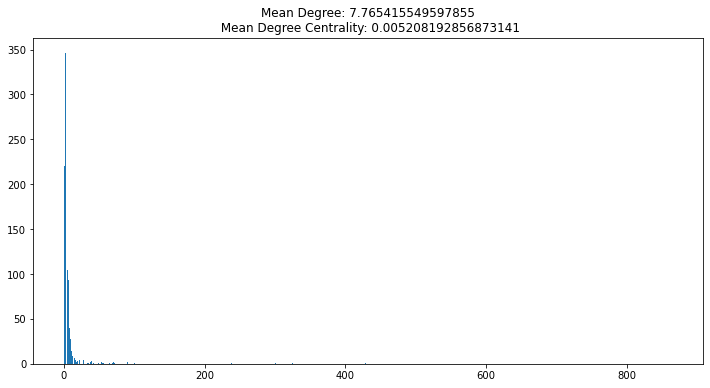

In [11]:
histdegree = pd.DataFrame(nx.degree_histogram(nx_graph))
degree = dict(nx.degree(nx_graph))

mean_degree = np.mean(list(degree.values()))
mean_degree_centrality = np.mean(list(nx.degree_centrality(nx_graph).values()))

fig, ax = plt.subplots(figsize=(12,6)) 
ax.bar(histdegree.index.values,histdegree[0])

plt.title("Mean Degree: {n1}\n Mean Degree Centrality: {n2}".format(n1=mean_degree,n2=mean_degree_centrality))
plt.show()

In [13]:
# save the triples in a csv file
with open('medsur.csv', 'w') as f: 
    for s, p, o in g:
        f.write(f'{s},{p},{o} \n')

In [ ]:
# 1. Clusteren op persoon eigenschappen en outcome
# 2. Clusteren op persoon drugs en symptoms
# 3. Clusteren op persoon drugs en outcome
# 4. Clusteren op persoon symptoms en outcome
# 3. Outcome predicten op basis van persoon eigenschappen
# 4. Outcome predicten op basis van drugs
#.5. Outcome predicten op basis van symptoms
# 6. Outcome totaal prediction --> alle drie combineren 

# 7. Clustering op symptoms en drugs --> kijken welke symptomen bij welke drugs horen
# 8. Zoeken voor outliers in de clusters --> kijken of er symptomen zijn die niet bij de drugs passen
# 9. Kijken of die outliers in side-effects zitten

Number of found communitites 47
0th community: 
 {rdflib.term.URIRef('http://www.medsur.org/patient_90'), rdflib.term.URIRef('http://www.medsur.org/symptom/10047700')}
1th community: 
 {rdflib.term.URIRef('http://www.medsur.org/patient_99'), rdflib.term.URIRef('http://www.medsur.org/drug/N02AX02'), rdflib.term.URIRef('http://www.medsur.org/patient_51'), rdflib.term.URIRef('http://www.medsur.org/patient_97'), rdflib.term.URIRef('http://www.medsur.org/patient_43'), rdflib.term.URIRef('http://www.medsur.org/patient_88'), rdflib.term.URIRef('http://www.medsur.org/patient_86'), rdflib.term.URIRef('http://www.medsur.org/patient_91'), rdflib.term.URIRef('http://www.medsur.org/symptom/10012174'), rdflib.term.URIRef('http://www.medsur.org/patient_1'), rdflib.term.URIRef('http://www.medsur.org/symptom/10018964'), rdflib.term.URIRef('http://www.medsur.org/patient_96'), rdflib.term.URIRef('http://www.medsur.org/patient_50')}
2th community: 
 {rdflib.term.URIRef('http://www.medsur.org/patient_28'),

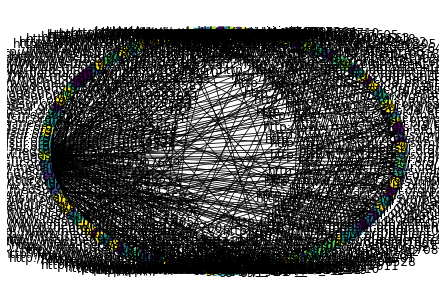